In [16]:
%pip install lxml
%pip install html5lib
%pip install beautifulsoup4
#import piplite
#await piplite.install('seaborn')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import seaborn as sns
%matplotlib inline
import pandas as pd
import requests
%pip install gspread
import gspread

# Funemployment Travel Expenses Breakdown

## Intro
Basically I went travelling for about 5 months. Went to Nepal, Thailand, Vietnam, Cambodia, and Australia for a wee bit. Decided to record all my spending in my [Travel Expenses](https://docs.google.com/spreadsheets/d/1gmgPb7LL3Lv-QZ47qMdRNX5tWyAgft7BPlYVrKH-VjI/edit?gid=1434497836#gid=1434497836), and now have a dataset with over 1000 rows of data.

The purpose of this notebook is for me to practice using Python for data analysis on a dataset I created myself that can hopefully provide some useful insights.

I broke my spending down into 7 categories which have been explained below.

**Accom**
- Accomodation costs while travelling. Every night was made as a seperate entry. E.g. if I stayed at a hotel and paid \$50 for 5 nights, it would have 5 entries at \$10 each
  
**Flights**
- Any international flight I took
- My flight path as New Zealand --> Nepal --> Thailand --> Vietnam --> Thailand --> Cambodia --> Australia --> New Zealand

**Food**
- Food costs while travelling. Anything I could eat or drink is in this category

**Tourist Shit**
- Fees for touristy things I did. Includes trekking permits for Nepal, entrance fees for holy sites, museums, etc

**Transport**
- In country transport.
- Includes buses betewen cities, taxis, and hiring personal motorbikes

**Travel Insurance**
- Just my travel insurance for while I was away

**Misc**
- Any other expense I had
- Covers unforeseen expenses, such as money that was lost when checking out of a hotel early. E.g. If I booked and paid \$50 for 5 nights at a hotel, but only stayed 2 nights. \$30 of that then became Misc cost.
- Also covers random supplies like mosquito spray, deodorant, and whatever else
- Got a couple tattoos at one point which is also covered here

### Defining functions

Goal is to create functions here that will allow for the whole sheet to be parsed as easily as posible. Want to try create functions that can be used if different currencies are added later.


In [3]:
#To get an overall view of spending proportions in each country
def overall(data, currency = ''):
    if currency != '':
        data = data.loc[data['Currency'] == currency]
    by_category = data.groupby('Purchase Category')['NZD Converted'].sum()
    plt.pie(by_category, autopct='%1.1f%%')
    plt.title(f'{currency} Overall Spending Proportions')
    plt.legend(labels = by_category.index, loc ='upper left', fontsize="7.5")

In [4]:
#1 NZD roughly equal to amounts specified in dictionary below
def convert(currency):
    currency_conversions = {'NPR': 81.2808, 'THB': 19.8176, 'VND': 14863.1, 'KHR': 2235.02, 'NZD': 1}
    return currency_conversions[currency]

In [5]:
def total_spend(data, currency = ''):
    if currency != '':
        data = data.loc[data['Currency'] == currency]
    total_spend = data['NZD Converted'].sum()
    print(f'${"%.2f" % total_spend} total spent\n')

In [6]:
def find_median(data, currency):
    plot = data[['Timestamp', 'NZD Converted']].loc[data['Currency'] == currency]
    plot = plot.groupby('Timestamp')['NZD Converted'].sum()
    return plot.median()
def find_mean(data, currency):
    plot = data[['Timestamp', 'NZD Converted']].loc[data['Currency'] == currency]
    plot = plot.groupby('Timestamp')['NZD Converted'].sum()
    return plot.mean()

In [7]:
def box_whisker(data, currency):
    plot = data[['Timestamp', 'NZD Converted']].loc[data['Currency'] == currency]
    plot = plot.groupby('Timestamp')['NZD Converted'].sum()
    plt.boxplot(plot, showmeans = True, meanline = True)
    plt.ylabel('$ NZD')
    plt.xlabel(f'Daily {currency}')
    mean = mpatch.Patch(color='green', label=(f'Mean = {"%.1f" % plot.mean()}'))
    median = mpatch.Patch(color='orange', label=(f'Median = {"%.1f" % find_median(data, currency)}'))
    plt.legend(handles=[mean, median])
    plt.title('Average Daily Expense')


In [8]:
def bar(data, currency = ''):
    if currency != '':
        data = data[['Purchase Category', 'NZD Converted']].loc[data['Currency'] == currency]
    data = data.groupby('Purchase Category')['NZD Converted'].sum()
    ax = data.plot.bar(width = .75 )
    ax.bar_label(ax.containers[0], fmt='$%.1f')
    plt.title(f'{currency} Total Spend by Category')

In [9]:
def bar_pie(data, currency = ''):
    fig, ax = plt.subplots(1, 2, figsize = (10,5))

    plt.subplot(1,2,1) #subplotting bar graph
    bar(data, currency)
    plt.xlabel('')

    plt.subplot(1,2,2) #subplotting pie chart
    overall(data,currency)

In [10]:
def analyse(data, currency = ''):
    total_spend(data, currency)
    bar_pie(data, currency)

In [11]:
#Compares daily spend by country
def country_by_daily(data):
    currencies = list(set(data['Currency'])) #Creating a list of currencies
    dailies = {}
    for x in currencies:
        if x == 'NZD':
            continue
        dailies[x] = find_median(expense_sheet, x), find_mean(expense_sheet, x) #creating a dictionary with median/mean values for each country


    data = pd.DataFrame(dailies, index = ['Median', 'Mean']).T #converting dictionary to dataframe
    ax = data.plot(kind = 'bar')
    plt.title('Median/Mean Daily Spend in NZD by Country')

In [12]:
def food_accom_daily(data, currency):
    #food= data[['Purchase Category'=='Food']]
    food = data[['Timestamp', 'Purchase Category', 'NZD Converted']].loc[(data['Currency'] == currency) & (data['Purchase Category'] == 'Food')]
    food = food.groupby('Timestamp')['NZD Converted'].sum()
    accom = data[['Timestamp', 'Purchase Category', 'NZD Converted']].loc[(data['Currency'] == currency) & (data['Purchase Category'] == 'Accom')]
    accom = accom.groupby('Timestamp')['NZD Converted'].sum()

    y = [accom.median(), food.median()]
    x = ['Accom Median', 'Food Median']
    ax = plt.bar(x, y)
    plt.title('Daily Mean/Median for Food/Accom')
    plt.bar_label(ax, fmt='$%.1f')

In [13]:
def daily(data, currency):
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    plt.subplot(1,2,1) #subplotting bar graph
    box_whisker(data, currency)
    plt.xlabel('')

    plt.subplot(1,2,2) #subplotting pie chart
    food_accom_daily(data,currency)

### Importing and Preparing Data

In [18]:
expense_sheet = pd.read_csv('Travel_Expenses.csv', skiprows=13, parse_dates = True, usecols=['Timestamp', 'Purchase Category', 'How much did you spend?', 'Notes', 'Currency', 'Cash/Card'])


In [19]:
currencies = list(set(expense_sheet['Currency']))

In [20]:
#Removing Cash out entries as those are irrelevant to this analysis
expense_sheet = expense_sheet[expense_sheet['Purchase Category'] != 'Cash Out']
#Resetting the index to adjust for Cash Out rows being deleted
expense_sheet = expense_sheet.reset_index()
del expense_sheet['index']

In [21]:
#Adding in a column for NZD Converted spending values
for x in range(len(expense_sheet)):
    expense_sheet.loc[x, 'NZD Converted'] = expense_sheet.loc[x, 'How much did you spend?']/convert(expense_sheet.loc[x, 'Currency'])

In [22]:
#Changing all Pisspot expenses to come under food and drink category
expense_sheet.loc[expense_sheet['Purchase Category'] == 'Pisspot', 'Purchase Category'] = 'Food'

In [23]:
#Converting timestamp column to datetime object so it can be manipulated
#expense_sheet['Timestamp'] = pd.to_datetime(expense_sheet['Timestamp'])
expense_sheet['Timestamp'] =  pd.to_datetime(expense_sheet['Timestamp']).dt.date


In [24]:
sns.set_theme(style="darkgrid")

# Overall

$16020.51 total spent



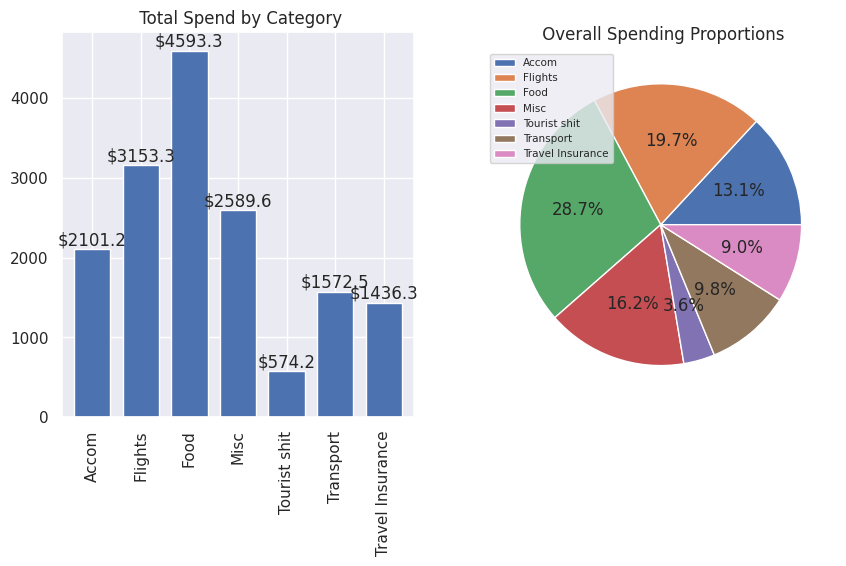

In [25]:
analyse(expense_sheet)

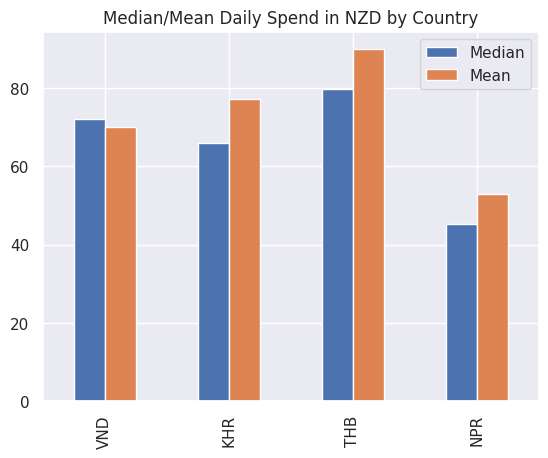

In [26]:
country_by_daily(expense_sheet)

## Discussion
The above graphs provide a nice general oversight as to how much I spent while travelling.

Unsuprisingly food was the biggest expense, followed by the Flights category.
My flights were New Zealand --> Nepal --> Thailand --> Vietnam --> Thailand --> Cambodia --> Australia --> New Zealand
Considering this just over $3000 is a reasonable amount to spend on flights a NZ is an expensive country to get to/from

Travel insurance was \$900 for Nepal and \$550 for Southeast Asia (Cambodia, Laos, Vietnam and Thailand). I ended up spending a lot more on travel insurance as I had to get a special insurance for trekking at high altitudes in Nepal through [World Nomads](https://www.worldnomads.com/nz/travel-insurance?gad_source=1&gclid=CjwKCAiAzPy8BhBoEiwAbnM9O7N4eExXGJG5ivXmSSMK9-O01RW1yCcdNSIfkKnQ5MJmWo7yU2IvfxoCKtAQAvD_BwE), which cost a lot more. The Southeast Asia travel insurance was also more expensive as I booked it in November, while in Nepal. Because of this I couldn't used an NZ based travel insurance provider and had to use World Nomads again, which cost more. For context, my partner spent \$370 for her travel insurance for Southeast Asia from AA.

In total I spent around \$17000 for 5 months (152 days) of traveling. This equated to a rough budget of around \$100 NZD a day, all inclusive of all my expenses while travelling.

The next sections will contain a more in depth analysis of each countries individual spending

# Nepal
## 11th September 2024 - 8th November 2024

$3168.95 total spent



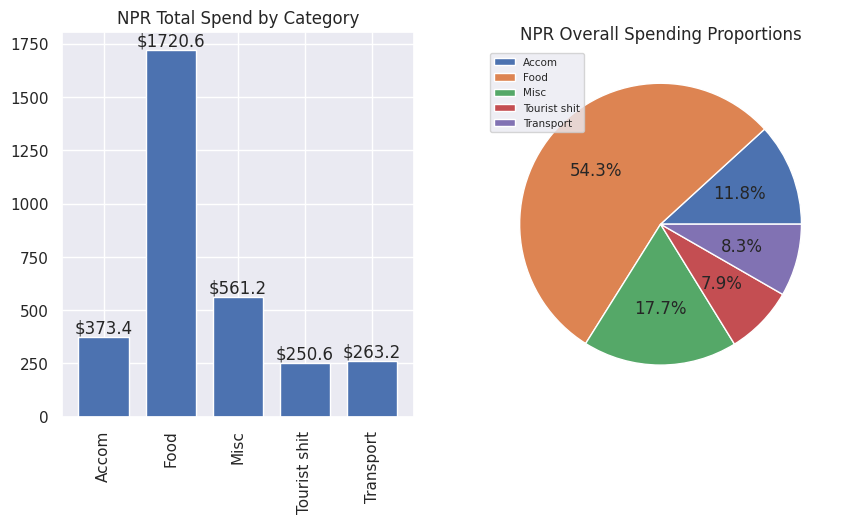

In [27]:
analyse(expense_sheet, 'NPR')

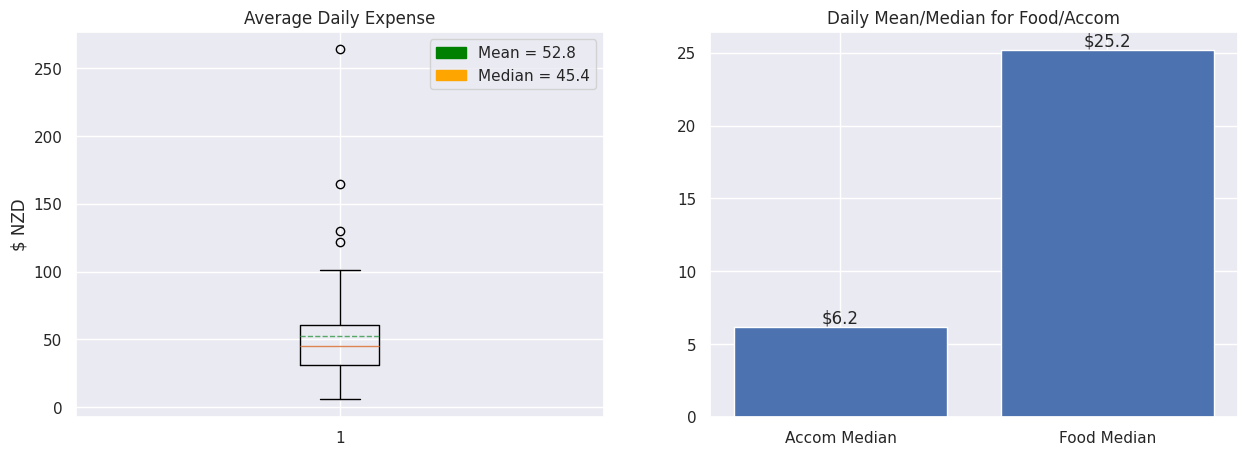

In [28]:
daily(expense_sheet, 'NPR')

## Discussion
Overall Nepal was by far the cheapest country I went to. With a median daily spend of $45 NZD, it's very affordable for a budget traveller.

My biggest expense by far was food, taking up over half of my total expenditure.

I came to Nepal with the intention of trekking in the Himalayas, and that was basically all I did. During my two months there I did the Annapurna Circuit and Three Passes circuit. While trekking my only expenses were food and accom. While trekking it was very common, especially in Annapurna, to recieve a free room at a Teahouse if you had dinner and breakfast there. This meant I had many nights where I did not need to pay for accomodation. On nights where I did pay it was generally 500 rupees (\$6 NZD) for a room, so still very cheap. This left food as the biggest expense while trekking. Food got significantly more expensive the higher in altitude you went while trekking, which is understandable as it has to be brought up to these remote villages via Yak. For context, a Dahl Bat cost about 200-300 Rupees (\$2.5-3.7 NZD) in Pokhara, but cost anywhere from 900-1200 Rupees (\$11-14.8 NZD) above 4500m. I stocked up on lots of snacks before trekking so I could eat them throughout the day while hiking and avoid having to buy a lunch in order to save money.

For anybody considering going to Nepal, it's important to know that the country has mandated having a qualified trekking guide with you while trekking in Nepal. However, many regions have not enforced this ruling and it is still possible and solo. Annapurna and Everest regions, where I trekked, were two of these regions, meaning I was able to trek solo without a guide. Please be aware though, if you are not confident solo trekking and educated on  altitude sickness, it is definitely much safer to get a guide. Just because people CAN still trek solo does not mean you SHOULD. If you get a guide, I heard it costs roughly \$30 USD (\$54 NZD) a day for one. There are also tour companies that organise entire treks for you. I met one guy who spent \$1900 USD (\$3400 NZD) on a 18 day Three Passes trek. This included accom, food, guides and flights to/from Lukla. Lots of people hired porters as well to carry their bags which cost about $10-15 USD (\$18-36 NZD) per day from what I heard.

Lukla is the airport that many fly into before starting the Everest Base Camp/Three Passes treks. I elected not to do this as flights costed about \$150-200 USD (\$270-360 NZD). Instead I took a jeep to Salleri for 5000 Rupees (\$60 NZD) and trekked from there. This added on a couple days trekking for me, which I was fine with. Be aware though, Nepalese roads are awful, and the Jeep ride took us about 20 hours. For me, who had an abundance of time, it was worth it though.

Transport in Nepal is cheap, but the roads are terrible. It was not uncommon on a bus trip in Nepal to stop for a few hours while a landslide was cleared from the road. The infrastructure is simply dogshit. There are airports around the country, in Pokhara and Lukla for example, and helicopters can be hired to fly you anywhere, but for anybody who's budget conscious, the 1500 Rupee (\$18 NZD) 15 hour bumpy bus ride is the preferred option. Watching the locals haul goats onto the roof of a bus from Salleri to Kathmandhu and sit there with them for the rest of the bus ride was a great memory as well. I like to say it's either a great idea or a great memory. All my Nepalese bus trips provided great memories.

Other expenses for Nepal worth noting included a 90 day visa (\$264 NZD) and trekking permits. Annapurna was 3000 Rupees (\$37 NZD) and Sagamartha National Park was 6000 Rupees (\$74 NZD).

In conclusion Nepal was by far, the roughest country I went to while Funemployed, but also the most memorable. Trekking can be done dirt cheap, but for those looking for a bit more comfort, the easier option is always there if you're willing to pay more.

# Thailand
## 8th November 2024 - 26th November 2024/12th December 2024 - 11th January 2025

$4492.55 total spent



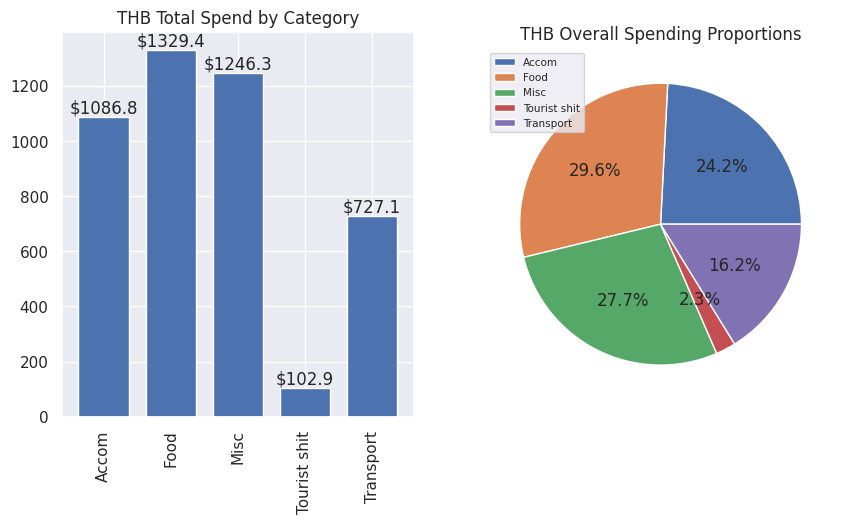

In [29]:
analyse(expense_sheet, 'THB')

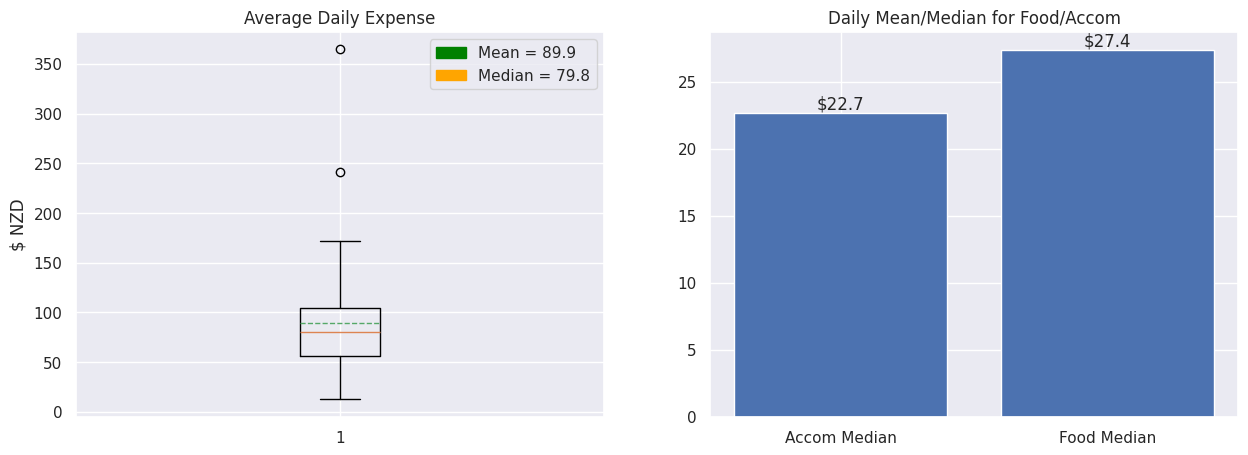

In [30]:
daily(expense_sheet, 'THB')

## Discussion
Going from the cheapest country I travelled in, to what would turn out to be the most expensive was a shock to the system and took me a little bit to get over. Let it be known, Thailand is still cheap, just not as cheap.

Firstly, it's important to note that I met up with my partner in Thailand and spent the rest of my Funemployment traveling with her. This meant that accomodation changed from dorms when not trekking in Nepal, to hotel rooms split with my partner. Therefore comparing accomodation costs between SE Asia and Nepal is a bit moot as they were very different types. Anecdotally though, it did seem that splitting a hotel room most of the time was about the same as what a dorm would end up have costing a solo traveller in SE Asia. We splashed out a couple times to stay at nicer places which cost a bit more, but for the most part we were pretty comfortably in the mid price range of hotels across SE Asia.

You may also notice in the box and whisker plot for daily spending in Thailand, is that the mean is significantly higher, indicating a stronger presence of outliers. The most expensive day in Thailand I spent \$364 NZD. This was my third day in Bangkok where I spent \$200 to ship back my cold weather clothes and hiking gear I used in Nepal to NZ, as I wouldn't need it for SE Asia. I also spent \$40 on a SIM card, which were all suprisingly expensive in Thailand.

The 2nd most expensive day I had was when we left Koh Tao early. We left on the 26th of December, but our accom was booked until the 6th of Jan. Since we left early, I took the daily room cost for the 26th-6th and combined it into a Misc entry, totalling about \$200 NZD.

Thailand had the highest Misc costs by far. These were generally things that could not have been planned for such as getting a ticket for driving a motorbike, missing our first ferry to Koh Tao due to flooding, leaving Koh Tao early, and getting a couple tattoos among other things.

Food in Thailand was generally pretty affordable. For 80-150 Baht(\$4-7.5 NZD) you could easily get a very good meal. We even went to a couple michellin star restaurants which cost 500+ (\$25 NZD) Baht, but they were amazing and very worth it. 7-Eleven was our best friend with 50 Baht (\$2.5 NZD) protein shakes and a whole range of toasties, burgers and other treats. In terms of food, I would confidently say Thailand was generally the best in terms of quality and taste. Ironically though, my partner did get food poisoning on Koh Tao from some poorly cooked Italian food. Street food was amazing and never gave us any problems though. 20 Baht (\$1 NZD) meat sticks were a large staple of our diet.

Transport costs in Thailand, as well as the rest of SE Asia are a lot higher too. This was because we would frequently rent motorbikes. They generally cost 200-300 (\$10-15 NZ) Baht per day and made getting around a lot better.

Thailand was my least favourite country I visited while Funemployed, but I still loved it. Personally I preferred the North significantly more than the South. It was cheaper overall and had a better vibe. Beaches and islands in the South invite a lot of party culture with loud, obnoxious, and disrespectful travellers. For me and my partner, who don't enjoy that at all, it made southern Thailand far less appealing. Me and my partner also both got kicked in the teeth with Norovirus, which was quite miserable.

# Vietnam
## 26th November 2024 - 12th December 2024

$1259.03 total spent



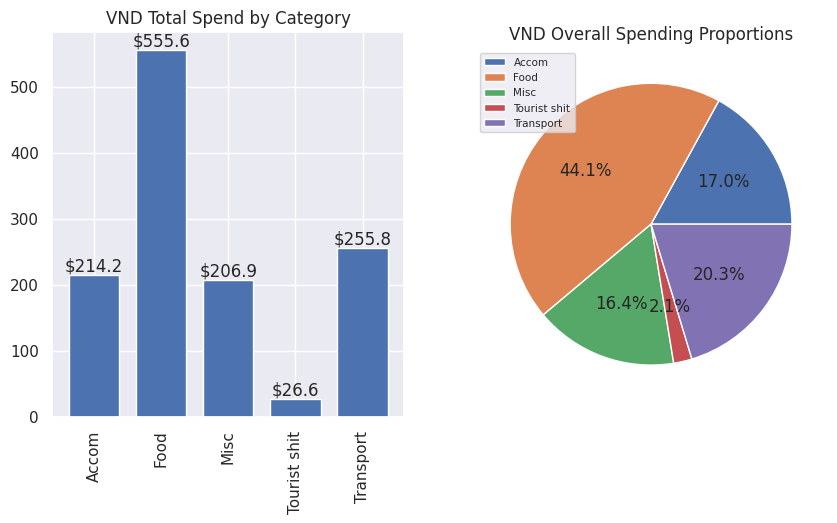

In [31]:
analyse(expense_sheet, 'VND')

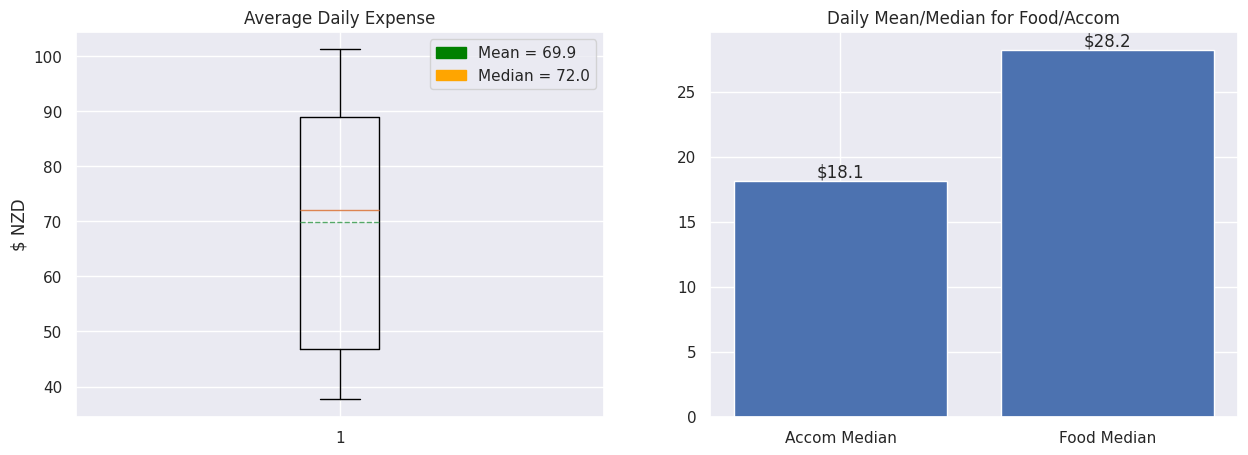

In [32]:
daily(expense_sheet, 'VND')

## Discussion
Not a huge amount to say for Vietnam. Was cheaper than Thailand which is nice.

Food was generally 50,000-100,000 Dong (\$3.5-7 NZD) for a meal with some more expensive cafes costing about 140,000 (\$10 NZD). Vietnamese food is amazing though and we ate a lot of Pho while travelling Vietnam. Vietnamese coffee is also great. Egg coffee was a personal favourite and generally cost around 60,000 Dong(\$4 NZD). I ended up averaging 3-4 coffees a day because of how good it was.

Transport was probably a bit more expensive on average. We took a lot of sleeper busses which cost $50-90 NZD, but did have the benefit of technically being a nights accomodation too. We only got scooters once for 150,000 Dong (\$10 NZD) per day in Ninh Binh, so cost was comparable to Thailand.

Accom was a lot cheaper and as a result we got many nice places in Vietnam for less than Thailand. A personal favourite was our room in Sapa which had amazing views overlooking the whole valley for 130,000 Dong (\$9 NZD) per night.

Overall, I really enjoyed Vietnam, despite spending the least amount of time there. North Vietnam is far better than South in my opinion though. Ho Chi Minh City left a lot to be desired for me personally. Was very chaotic, dirty, and reeked of hot trash.

# Cambodia
## 11th January 2025 - 7th February 2025

$2158.82 total spent



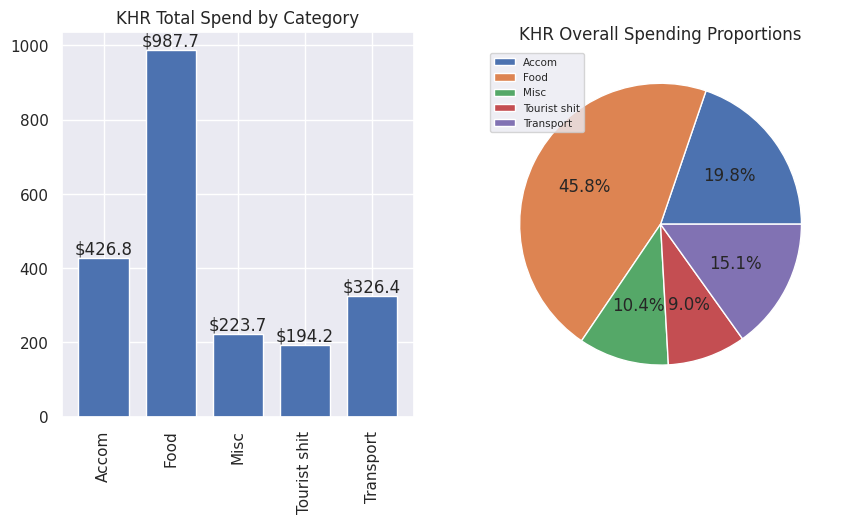

In [33]:
analyse(expense_sheet, 'KHR')

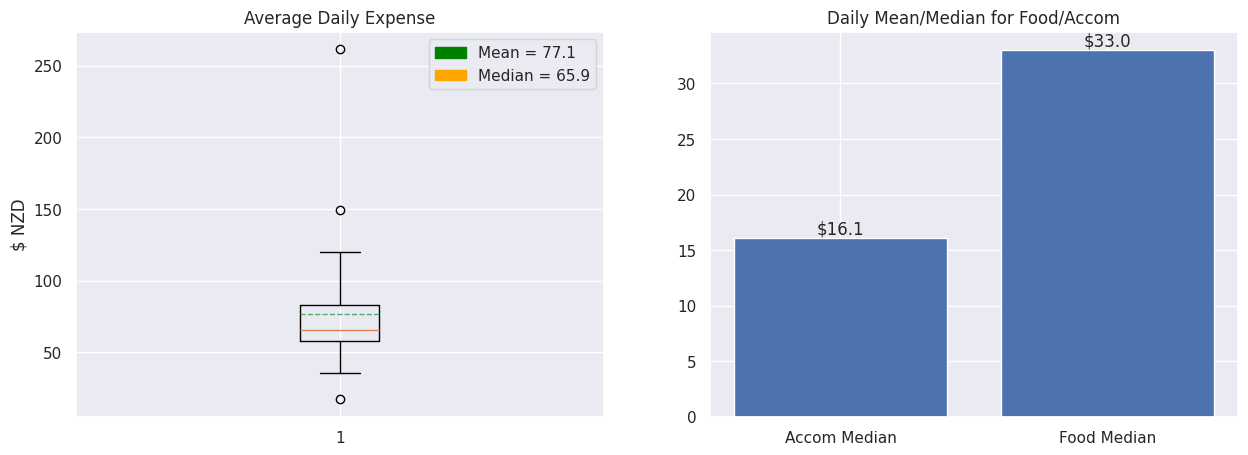

In [34]:
daily(expense_sheet, 'KHR')

## Discussion
Cambodia was the last country we visited before making it back to NZ. Spent a month there and it was lovely overall. Certain things were weirdly expensive, but otherwise it was quite cheap.

Siem Reap was the most expensive place we stayed in by far. A 3 day Angkor pass was \$62 USD (\$107 NZD) and we got coerced into spending \$20 USD (\$34 NZD) for a guide who drove us into and around the major sites in Angkor for a day. Honestly, wasn't worth it. Hiring bikes or a Tuk Tuk is definitely a much better way to go for visitting Angkor, which is AMAZING. Easily one of my favourite places I visited and seriously worth the $100 NZD for a 3 day pass.

Outside of Siem Reap and Phnom Penh, things were a lot cheaper. We stayed in a town in the far north called Banlung for a week and spent \$4.5 USD (\$7.4 NZD) a night for a lovely cabin homestay just out of town. While it wasn't as luxurious as a 4 star hotel, the cabin was very worth it.

One thing that was suprisingly expensive in Cambodia however was food. In general we found the best food in Cambodia, wasn't Cambodian food. We had amazing Italian, Lebanese and Mexican food, all of which were more expensive than other countries in SEA. For example, we spent \$14 USD (\$24 NZD) on a Lasagna in Mondulkiri, which was amazing, but expensive. For cheaper Cambodian food, we were generally spending around \$4 USD (\$7 NZD) on average for a main. In Banlung, we ate Chicken Amok every day for \$4 USD and I would add on 6 eggs for \$3 USD to get my protein in totalLing \$7 USD (\$12 NZD).

It's also worth noting that Cambodia trades in both Cambodian Riel (KHR) and US Dollar (USD). \$1 USD was generally equal to 4000 KHR and you could pay at stores with either. For the most part we always just used KHR to pay for everything.

In [63]:
!pip install pypandoc
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Funemployment.ipynb', notebookpath="/content")

File ‘colab_pdf.py’ already there; not retrieving.



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's conf

'File Download Unsuccessful. Saved in Google Drive'